In [271]:
import numpy as np
import cv2
import glob
import time
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip

%matplotlib inline
plt.style.use('ggplot')

In [7]:
def plot_images(images, cols=5, figsize=(8, 4)):
    n_img = len(images)
    rows = math.ceil(n_img/cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    subplots = axes.ravel()

    for n, subplot in enumerate(subplots):
        if (n < n_img):
            image = images[n]
            if len(image.shape) < 3:
                subplots[n].imshow(image, cmap='gray')
            else:
                subplots[n].imshow(image)
            subplots[n].axis('off')
        else:
            subplots[n].axis('off')
    plt.show()

# Histogram of Oriented Gradients (HOG)

In [8]:
sample_files = glob.glob('test_images/*.jpg')
sample_images = []

for file in sample_files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_images.append(img)

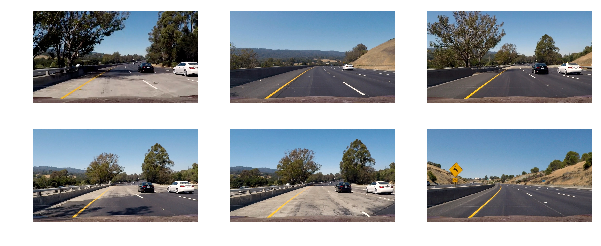

In [10]:
plot_images(sample_images, cols=3, figsize=(10, 4))

In [158]:
img = np.copy(sample_images[0])
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [159]:
pixel_per_cell = 8
pixels_per_cell = (pixel_per_cell, pixel_per_cell)
cell_per_block = 2
cells_per_block = (cell_per_block, cell_per_block)
orient = 9

features, hog_img = hog(gray[360:(360+180), (1280-320):1280], 
                          orientations=orient,
                          pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block,
                          visualise=True,
                          feature_vector=False)

In [160]:
gray.shape

(720, 1280)

In [68]:
features.shape

(21, 39, 2, 2, 9)

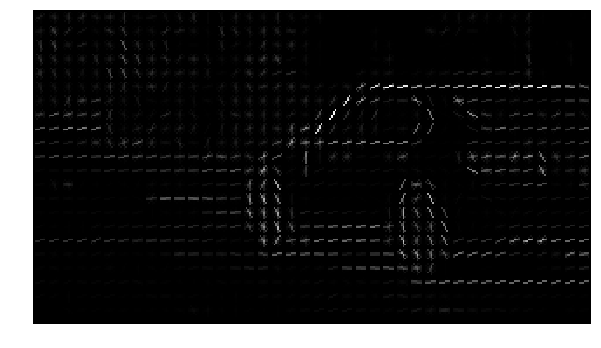

In [161]:
plt.figure(figsize=(10, 6))
plt.imshow(hog_img, cmap='gray')
plt.axis('off')
plt.show()

In [190]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()

    return features

In [191]:
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(
        (channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [70]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orientations, pix_per_cell, cell_per_block,
                     visualise=False, feature_vector=True):

    pixels_per_cell = (pix_per_cell, pix_per_cell)
    cells_per_block = (cell_per_block, cell_per_block)

    # Call with two outputs if vis==True
    if visualise is True:
        features, hog_image = hog(img,
                                  orientations=orientations,
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block,
                                  transform_sqrt=True,
                                  visualise=visualise,
                                  feature_vector=feature_vector)
        return features, hog_image

    # Otherwise call with one output
    else:
        features = hog(img,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       transform_sqrt=True,
                       visualise=visualise,
                       feature_vector=feature_vector)
        return features

In [72]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(images, cspace='RGB', orientations=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0):

    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for file in images:
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_feats = []
            for channel in range(feature_image.shape[2]):
                hog_feat = get_hog_features(feature_image[:, :, channel],
                                            orientations,
                                            pix_per_cell,
                                            cell_per_block,
                                            visualise=False,
                                            feature_vector=True)
                hog_feats.append(hog_feat)
            hog_features = np.ravel(hog_feats)

        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel],
                                            orientations,
                                            pix_per_cell,
                                            cell_per_block,
                                            visualise=False,
                                            feature_vector=True)

        # Append the new feature vector to the features list
        features.append(hog_features)

    # Return list of feature vectors
    return features

# HOG Classifier

## Feature Extraction

In [212]:
# Divide up into cars and notcars
images = glob.glob('data/*_smallset/**/*.jpeg')
print('Loading {} images...'.format(len(images)))

cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 2000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 1 # Can be 0, 1, 2, or "ALL"

t = time.time()

car_features = extract_features(cars, 
                                cspace=colorspace, 
                                orientations=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

notcar_features = extract_features(notcars, 
                                   cspace=colorspace, 
                                   orientations=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

Loading 2321 images...
4.71 Seconds to extract HOG features...


In [213]:
car_features[0].shape

(1764,)

In [214]:
mpimg.imread(cars[0]).shape

(64, 64, 3)

## Model Training

In [215]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = 123  # np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...\n')

# Check the score of the SVC
print('Test Accuracy of SVC = {}\n'.format(round(svc.score(X_test, y_test), 4)))

# Check the prediction time for a single sample
t = time.time()
n_predict = 18

print('My SVC predicts:\n {}\n'.format(svc.predict(X_test[0:n_predict])))
print('For these {} labels:\n {}\n'.format(n_predict, y_test[0:n_predict]))

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC\n')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.15 Seconds to train SVC...

Test Accuracy of SVC = 0.9763

My SVC predicts:
 [ 1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.]

For these 18 labels:
 [ 1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.]

0.00122 Seconds to predict 18 labels with SVC



## Accuracy Performance of Color Spaces

#### Hog Channel 0

```
| RGB    | 0.9527 |
| HSV    | 0.9613 |
| LUV    | 0.9634 |
| HLS    | 0.9656 |
| YUV    | 0.9441 |
| YCrCb  | 0.9634 |
```

#### Hog Channel 1

```
| RGB    | 0.9527 |
| HSV    | 0.9355 |
| LUV    | 0.9677 |
| HLS    | 0.9613 |
| YUV    | 0.9763 |
| YCrCb  | 0.972  |
```

#### Hog Channel 2

```
| RGB    | 0.9527 |
| HSV    | 0.9591 |
| LUV    | 0.972  |
| HLS    | 0.9376 |
| YUV    | 0.957  |
| YCrCb  | 0.957  |
```

#### Hog Channel ALL

```
| RGB    | 0.9613 |
| HSV    | 0.9828 |
| LUV    | 0.9935 |
| HLS    | 0.9785 |
| YUV    | 0.9914 |
| YCrCb  | 0.9935 |
```

# Sliding Window

In [145]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(image, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined,
    # set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [147]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thickness=6):
    imcopy = np.copy(img)

    for bbox in bboxes:
        cv2.rectangle(img=imcopy, pt1=bbox[0], pt2=bbox[1],
                      color=color, thickness=thickness)
    return imcopy

In [181]:
windows = slide_window(img, 
                       x_start_stop=[None, None], 
                       y_start_stop=[None, None], 
                       xy_window=(128, 128), 
                       xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(img, windows, 
                        color=(255, 80, 0), 
                        thickness=4)                    

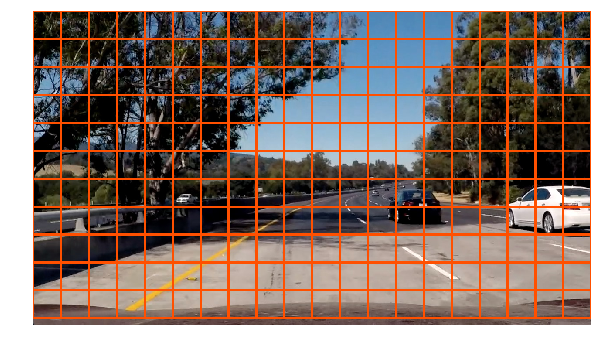

In [182]:
plt.figure(figsize=(10, 6))
plt.imshow(window_img)
plt.axis('off')
plt.show()

In [183]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orientations=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = []

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)

    if spatial_feat is True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat is True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat is True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(
                    get_hog_features(feature_image[:, :, channel],
                                     orientations,
                                     pix_per_cell, cell_per_block,
                                     visualise=False,
                                     feature_vector=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel],
                                            orientations,
                                            pix_per_cell, cell_per_block,
                                            visualise=False,
                                            feature_vector=True)

        img_features.append(hog_features)

    return np.concatenate(img_features)


In [216]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orientations=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):

    on_windows = []

    for window in windows:
        # Extract the test window from original image
        patch_img = img[window[0][1]:window[1][1],
                        window[0][0]:window[1][0]]
        test_img = cv2.resize(patch_img, (64, 64))

        # Extract features for that window using single_img_features()
        features = single_img_features(test_img,
                                       color_space=color_space,
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       orientations=orientations,
                                       pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel,
                                       spatial_feat=spatial_feat,
                                       hist_feat=hist_feat,
                                       hog_feat=hog_feat)

        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        # Predict using your classifier
        prediction = clf.predict(test_features)

        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    # Return windows for positive detections
    return on_windows


In [267]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 1 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [int(img.shape[0]*1/3), None] # Min and max in y to search in slide_window()

draw_image = np.copy(img)

windows = slide_window(img,
                       x_start_stop=[None, None],
                       y_start_stop=y_start_stop,
                       xy_window=(96, 96),
                       xy_overlap=(0.5, 0.5))

hot_windows = search_windows(img,
                             windows=windows,
                             clf=svc,
                             scaler=X_scaler,
                             color_space=color_space,
                             spatial_size=spatial_size,
                             hist_bins=hist_bins,
                             orientations=orientations,
                             pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel,
                             spatial_feat=spatial_feat,
                             hist_feat=hist_feat,
                             hog_feat=hog_feat)


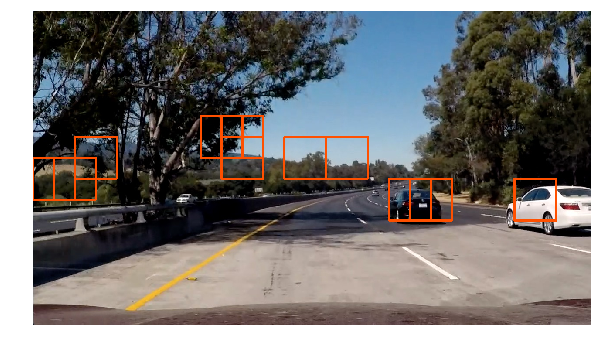

In [268]:
window_img = draw_boxes(draw_image, hot_windows, color=(255, 80, 0), thickness=4)

plt.figure(figsize=(10, 6))
plt.imshow(window_img)
plt.axis('off')
plt.show()

In [269]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


In [270]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

3 cars found


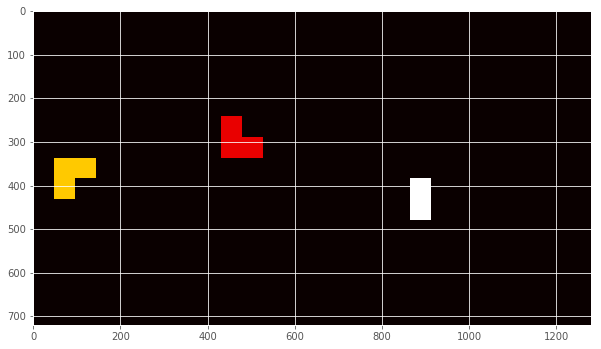

In [279]:
heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
add_heat(heatmap=heatmap, bbox_list=hot_windows)
labels = label(heatmap)
heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)

print(labels[1], 'cars found')

plt.figure(figsize=(10, 6))
plt.imshow(labels[0], cmap='hot')
plt.show()

In [285]:
def draw_labeled_bboxes(img, labels):

    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))

        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

    return img

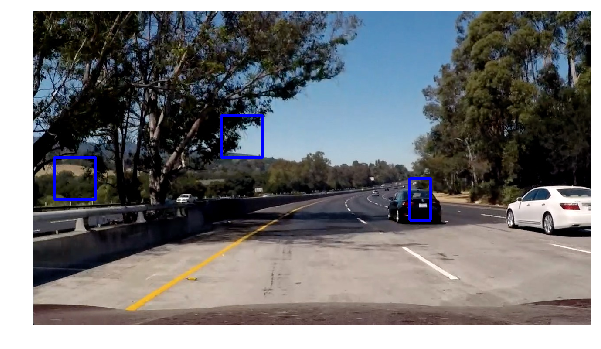

In [287]:
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(10, 6))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

In [ ]:
def process_image(image):
    
    return final_img

In [ ]:
def process_frame(image):
    try:
        frame = process_image(image)
    except Exception as e:
        frame = image
        print(e)
    finally:
        return frame

In [ ]:

%%time

video_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
# video_output = 'harder_challenge_video_output.mp4'
# clip = VideoFileClip('harder_challenge_video.mp4')
white_clip = clip.fl_image(process_frame)
white_clip.write_videofile(video_output, audio=False)